In [3]:
!nvidia-smi

Wed Jun 15 01:49:52 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
# mount driver
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/CardiacSeg/UNETCNX_SegTHOR

# install dependents
!pip install -q "monai-weekly[nibabel, tqdm, einops]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

# # install torch by gpu version
# import torch
# if torch.cuda.is_available() and torch.cuda.get_device_name(0) == 'Tesla T4':
#   !pip install -q torch==1.10.1+cu111 torchvision==0.11.2+cu111 torchaudio==0.10.1 -f https://download.pytorch.org/whl/torch_stable.html

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1jz_DGnICBmKWCr_JL904PDQdIEK0_EQG/CardiacSeg/UNETCNX_SegTHOR


In [5]:
from functools import partial

import torch
from torch import Tensor
import torch.nn as nn

import torch.nn.functional as F
import torchvision
from torchvision.models.convnext import ConvNeXt, CNBlockConfig, CNBlock
from torchvision.ops.stochastic_depth import StochasticDepth


from torchsummary import summary
from pprint import pprint
from typing import Optional, Callable, List, Any, Sequence

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## UNETCNX (UNetConvNeXt3D)

### Block

#### ConvNormActivation

In [7]:
import warnings


class ConvNormActivation(torch.nn.Sequential):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: int = 3,
        stride: int = 1,
        padding: Optional[int] = None,
        groups: int = 1,
        norm_layer: Optional[Callable[..., torch.nn.Module]] = torch.nn.BatchNorm2d,
        activation_layer: Optional[Callable[..., torch.nn.Module]] = torch.nn.ReLU,
        dilation: int = 1,
        inplace: Optional[bool] = True,
        bias: Optional[bool] = None,
        conv_layer: Callable[..., torch.nn.Module] = torch.nn.Conv2d,
    ) -> None:

        if padding is None:
            padding = (kernel_size - 1) // 2 * dilation
        if bias is None:
            bias = norm_layer is None

        layers = [
            conv_layer(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                dilation=dilation,
                groups=groups,
                bias=bias,
            )
        ]

        if norm_layer is not None:
            layers.append(norm_layer(out_channels))

        if activation_layer is not None:
            params = {} if inplace is None else {"inplace": inplace}
            layers.append(activation_layer(**params))
        super().__init__(*layers)
        self.out_channels = out_channels

        if self.__class__ == ConvNormActivation:
            warnings.warn(
                "Don't use ConvNormActivation directly, please use Conv2dNormActivation and Conv3dNormActivation instead."
            )

class Conv3dNormActivation(ConvNormActivation):
    """
    Configurable block used for Convolution3d-Normalization-Activation blocks.
    Args:
        in_channels (int): Number of channels in the input video.
        out_channels (int): Number of channels produced by the Convolution-Normalization-Activation block
        kernel_size: (int, optional): Size of the convolving kernel. Default: 3
        stride (int, optional): Stride of the convolution. Default: 1
        padding (int, tuple or str, optional): Padding added to all four sides of the input. Default: None, in which case it will calculated as ``padding = (kernel_size - 1) // 2 * dilation``
        groups (int, optional): Number of blocked connections from input channels to output channels. Default: 1
        norm_layer (Callable[..., torch.nn.Module], optional): Norm layer that will be stacked on top of the convolution layer. If ``None`` this layer wont be used. Default: ``torch.nn.BatchNorm3d``
        activation_layer (Callable[..., torch.nn.Module], optional): Activation function which will be stacked on top of the normalization layer (if not None), otherwise on top of the conv layer. If ``None`` this layer wont be used. Default: ``torch.nn.ReLU``
        dilation (int): Spacing between kernel elements. Default: 1
        inplace (bool): Parameter for the activation layer, which can optionally do the operation in-place. Default ``True``
        bias (bool, optional): Whether to use bias in the convolution layer. By default, biases are included if ``norm_layer is None``.
    """

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: int = 3,
        stride: int = 1,
        padding: Optional[int] = None,
        groups: int = 1,
        norm_layer: Optional[Callable[..., torch.nn.Module]] = torch.nn.BatchNorm3d,
        activation_layer: Optional[Callable[..., torch.nn.Module]] = torch.nn.ReLU,
        dilation: int = 1,
        inplace: Optional[bool] = True,
        bias: Optional[bool] = None,
    ) -> None:

        super().__init__(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            groups,
            norm_layer,
            activation_layer,
            dilation,
            inplace,
            bias,
            torch.nn.Conv3d,
        )

#### CN3D Block

In [8]:
class LayerNorm3d(nn.LayerNorm):
    def forward(self, x: Tensor) -> Tensor:
        x = x.permute(0, 2, 3, 4, 1)
        x = F.layer_norm(x, self.normalized_shape, self.weight, self.bias, self.eps)
        x = x.permute(0, 4, 1, 2, 3)
        return x


class Permute(nn.Module):
    def __init__(self, dims: List[int]):
        super().__init__()
        self.dims = dims

    def forward(self, x):
        return torch.permute(x, self.dims)


class CN3DBlock(nn.Module):
    def __init__(
        self,
        dim,
        layer_scale: float,
        stochastic_depth_prob: float,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = partial(nn.LayerNorm, eps=1e-6)

        self.block = nn.Sequential(
            nn.Conv3d(dim, dim, kernel_size=7, padding=3, groups=dim, bias=True),
            Permute([0, 2, 3, 4, 1]),
            norm_layer(dim),
            nn.Linear(in_features=dim, out_features=4 * dim, bias=True),
            nn.GELU(),
            nn.Linear(in_features=4 * dim, out_features=dim, bias=True),
            Permute([0, 4, 1, 2, 3]),
        )
        self.layer_scale = nn.Parameter(torch.ones(dim, 1, 1, 1) * layer_scale)
        self.stochastic_depth = StochasticDepth(stochastic_depth_prob, "row")

    def forward(self, input: Tensor) -> Tensor:
        result = self.layer_scale * self.block(input)
        result = self.stochastic_depth(result)
        result += input
        return result

#### UNet Block

In [9]:
class UnetBasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm3d(out_channels),
            nn.GELU(),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm3d(out_channels),
            nn.GELU(),
        )

    def forward(self, x):
        return self.conv(x)


class UnetUpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=2, stride=2, block=None):
        super().__init__()
        self.transp_conv = nn.ConvTranspose3d(in_channels, out_channels, kernel_size, stride, bias=False)
        if block is None:
          self.conv_block = UnetBasicBlock(out_channels + out_channels, out_channels)
        else:
          self.conv_block = nn.Sequential(
              block,
              UnetBasicBlock(out_channels + out_channels, out_channels)
          )
    def forward(self, inp, skip):
        # number of channels for skip should equals to out_channels
        out = self.transp_conv(inp)
        out = torch.cat((out, skip), dim=1)
        out = self.conv_block(out)
        return out


class UnetOutBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1, bias=False)
        )

    def forward(self, inp):
        return self.conv(inp)

### Net

In [10]:
class UNETCNX(ConvNeXt):
    def __init__(
        self,
        in_channels = 1,
        out_channels = 2,
        img_size = 96, 
        stochastic_depth_prob: float = 0.4,
        layer_scale: float = 1e-6,
        num_classes: int = 1000,
        block: Optional[Callable[..., nn.Module]] = CN3DBlock,
        norm_layer: Optional[Callable[..., nn.Module]] = LayerNorm3d,
        **kwargs: Any
    ) -> None:
        block_setting: List[CNBlockConfig] = [
            CNBlockConfig(img_size, 192, 3),
            CNBlockConfig(192, 384, 3),
            CNBlockConfig(384, 768, 3),
        ]
        super().__init__(
            block_setting,
            stochastic_depth_prob,
            layer_scale,
            num_classes,
            block,
            norm_layer
        )

        firstconv_output_channels = block_setting[0].input_channels
        self.features[0] = Conv3dNormActivation(
            in_channels,
            firstconv_output_channels,
            kernel_size=4,
            stride=4,
            padding=0,
            norm_layer=norm_layer,
            activation_layer=None,
            bias=True,
        )


        self.dec_features = []
        total_stage_blocks = sum(cnf.num_layers for cnf in block_setting)
        stage_block_id = 0
        for block_num, cnf in enumerate(block_setting, 1):
            # mdf orginal 2d downsampling to 3d downsampling
            if cnf.out_channels is not None:
                self.features[block_num * 2] =nn.Sequential(
                    norm_layer(cnf.input_channels),
                    nn.Conv3d(cnf.input_channels, cnf.out_channels, kernel_size=2, stride=2),
                )

            # build decoder layer
            stage = []
            for _ in range(cnf.num_layers):
                # adjust stochastic depth probability based on the depth of the stage block
                sd_prob = stochastic_depth_prob * stage_block_id / (total_stage_blocks - 1.0)
                stage.append(block(cnf.out_channels, layer_scale, sd_prob))
                stage_block_id += 1
            self.dec_features.append(nn.Sequential(*stage))


        self.inc = self.features[0]
        self.encoder1 = nn.Sequential(
            self.features[1],
            self.features[2],
        )
        self.encoder2 = nn.Sequential(
            self.features[3],
            self.features[4],
        )
        self.encoder3 = nn.Sequential(
            self.features[5],
            self.features[6],
        )

        self.decoder3 = UnetUpBlock(768, 384, block=self.dec_features[2])
        self.decoder2 = UnetUpBlock(384, 192, block=self.dec_features[1])
        self.decoder1 = UnetUpBlock(192, 96, block=self.dec_features[0])
        self.decoder0 = UnetUpBlock(96, 1, kernel_size=4, stride=4)

        self.out = UnetOutBlock(1, out_channels)

    def forward(self, x):
        inc = self.inc(x)
        enc1 = self.encoder1(inc)
        enc2 = self.encoder2(enc1)
        enc3 = self.encoder3(enc2)

        dec3 = self.decoder3(enc3, enc2)
        dec2 = self.decoder2(dec3, enc1)
        dec1 = self.decoder1(dec2, inc)
        dec0 = self.decoder0(dec1, x)
        return self.out(dec0)

In [11]:
model3 = UNETCNX(in_channels=1, out_channels=2, img_size=96).to(device)
summary(model3, (1, 96, 96, 96), batch_size=1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1        [1, 96, 24, 24, 24]           6,240
            Conv3d-2        [1, 96, 24, 24, 24]           6,240
       LayerNorm3d-3        [1, 96, 24, 24, 24]             192
       LayerNorm3d-4        [1, 96, 24, 24, 24]             192
            Conv3d-5        [1, 96, 24, 24, 24]          33,024
            Conv3d-6        [1, 96, 24, 24, 24]          33,024
           Permute-7        [1, 24, 24, 24, 96]               0
           Permute-8        [1, 24, 24, 24, 96]               0
         LayerNorm-9        [1, 24, 24, 24, 96]             192
        LayerNorm-10        [1, 24, 24, 24, 96]             192
           Linear-11       [1, 24, 24, 24, 384]          37,248
           Linear-12       [1, 24, 24, 24, 384]          37,248
             GELU-13       [1, 24, 24, 24, 384]               0
             GELU-14       [1, 24, 24, 

# 3D Cardiac Segmentation with Swin UNETCNX

In [12]:
import os
from pathlib import PurePath

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from monai.utils import first
from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    AddChanneld,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    ToTensord,
    LabelFilterd,
    MapLabelValued
)


from monai.metrics import DiceMetric, HausdorffDistanceMetric
from monai.networks.nets import SwinUNETR

from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)

import torch
from torch.utils.tensorboard import SummaryWriter

import pandas as pd

## Setup config

In [13]:
class Config:
  model_name = 'full_convnext'
  use_pretrained_model = False
  root_dir = './'
  data_dir = ''
  model_dir = os.path.join(root_dir, 'models', model_name)
  log_dir = os.path.join(root_dir, 'logs', model_name)
  eval_dir = os.path.join(root_dir, 'evals', model_name)
  pretrained_model_pth = os.path.join(model_dir, 'dc_91_best_metric_model.pth')
  batch_size = 1
  num_workers = 0
  cache_rate = 1.0
  pin_memory = False


class LoaclConfig(Config):
  data_dir = 'D:\\home\\school\\ntut\\dataset\\SegTHOR\\train'

class ColabConfig(Config):
  root_dir = './'
  data_dir = '../dataset/SegTHOR/train'
  num_workers = 2
  pin_memory = True

is_colab = True

if is_colab:
  config = ColabConfig
else:
  config = LoaclConfig

# setup dir
root_dir = config.root_dir
data_dir = config.data_dir
model_dir = config.model_dir
log_dir = config.log_dir
eval_dir = config.eval_dir

# make dir
os.makedirs(model_dir, exist_ok=True)
os.makedirs(log_dir, exist_ok=True)
os.makedirs(eval_dir, exist_ok=True)

# setup data loader param
batch_size = config.batch_size
num_workers = config.num_workers
cache_rate = config.cache_rate
pin_memory = config.pin_memory

# show dir
print(f'root_dir: {root_dir}')
print(f'data_dir: {data_dir}')
print(f'model_dir: {model_dir}')
print(f'log_dir: {log_dir}')
print(f'eval_dir: {eval_dir}')

root_dir: ./
data_dir: ../dataset/SegTHOR/train
model_dir: ./models/full_convnext
log_dir: ./logs/full_convnext
eval_dir: ./evals/full_convnext


## Setup transforms for training and validation

In [14]:
num_samples = 2

train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        LabelFilterd(keys=["label"], applied_labels=[2]),
        MapLabelValued(keys=["label"], orig_labels=[0,2], target_labels=[0,1]),
        AddChanneld(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-175,
            a_max=250,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=['image','label'], source_key='label',margin=40),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=num_samples,
            image_key="image",
            image_threshold=0,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[2],
            prob=0.10,
        ),
        RandRotate90d(
            keys=["image", "label"],
            prob=0.10,
            max_k=3,
        ),
        RandShiftIntensityd(
            keys=["image"],
            offsets=0.10,
            prob=0.50,
        ),
        ToTensord(keys=["image", "label"]),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        LabelFilterd(keys=["label"], applied_labels=[2]),
        MapLabelValued(keys=["label"], orig_labels=[0,2], target_labels=[0,1]),
        AddChanneld(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True
        ),
        CropForegroundd(keys=['image','label'], source_key='label',margin=40),
        ToTensord(keys=["image", "label"]),
    ]
)

## Setup dataset and data loader

In [15]:
def get_ds_pths(data_dir):
    img_pths = []
    lbl_pths = []
    for patient_dir in sorted(os.listdir(data_dir)):
        img_pths.append(os.path.join(data_dir, patient_dir, f'{patient_dir}.nii.gz'))
        lbl_pths.append(os.path.join(data_dir, patient_dir, f'GT.nii.gz'))
    return img_pths, lbl_pths


def get_data_dicts(data_dir):
    img_pths, lbl_pths = get_ds_pths(data_dir)
    data_dicts = [
        {"image": img_pth, "label": lbl_pth}
        for img_pth, lbl_pth in zip(img_pths, lbl_pths)
    ]
    return data_dicts

In [16]:
data_dicts = get_data_dicts(data_dir)
train_files, val_files = data_dicts[:10], data_dicts[10:15]

In [17]:
# setup ds and loader
train_ds = CacheDataset(
    data=train_files,
    transform=train_transforms,
    cache_rate=cache_rate,
    num_workers=num_workers,
)
train_loader = DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=pin_memory
)
val_ds = CacheDataset(
    data=val_files,
    transform=val_transforms,
    cache_rate=cache_rate,
    num_workers=num_workers
)
val_loader = DataLoader(
    val_ds,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=pin_memory
)

Loading dataset: 100%|██████████| 5/5 [00:31<00:00,  6.35s/it]


## Check data shape and visualize

image shape: torch.Size([179, 171, 120])
label shape: torch.Size([179, 171, 120])


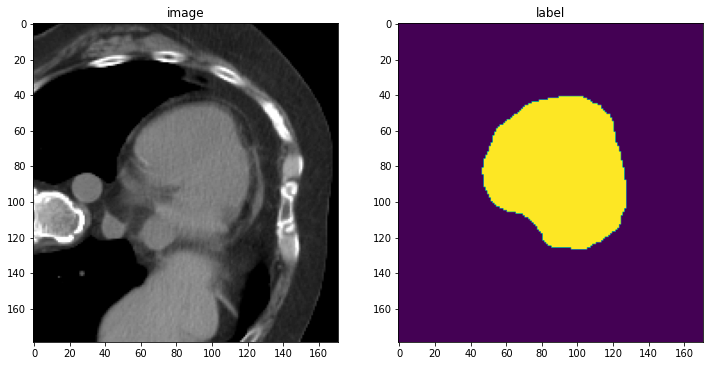

In [18]:
check_loader = DataLoader(val_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}")
print(f"label shape: {label.shape}")
# plot the slice [:, :, 120]
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 50], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 50])
plt.show()

## Create UNETCNX model

In [19]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    print("cuda is available")
    device = torch.device("cuda")
    torch.backends.cudnn.benchmark = True
else:
    print("cuda is not available")
    device = torch.device("cpu")

model = UNETCNX(
    in_channels=1,
    out_channels=2,
    img_size=96,
).to(device)


loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

cuda is available


## Execute a typical PyTorch training process

In [20]:
raise ValueError()

ValueError: ignored

In [21]:
use_pretrained_model = config.use_pretrained_model
pretrained_model_pth = config.pretrained_model_pth
if use_pretrained_model:
  model.load_state_dict(
      torch.load(
          pretrained_model_pth,
          map_location=device
      )
  )
  print(f'load pretrained model: {pretrained_model_pth}')
else:
  print(f'not load pretrained model')

not load pretrained model


In [22]:
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for step, batch in enumerate(epoch_iterator_val):
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [
                post_label(val_label_tensor) for val_label_tensor in val_labels_list
            ]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [
                post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list
            ]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description(
                "Validate (%d / %d Steps)" % (global_step, 10.0)
            )
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(
        train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True
    )
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].to(device), batch["label"].to(device))
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description(
            "Training (%d / %d Steps) (loss=%2.5f)"
            % (global_step, max_iterations, loss)
        )
        writer.add_scalar("tr_loss", loss, global_step=global_step)
        if (
            global_step % eval_num == 0 and global_step != 0
        ) or global_step == max_iterations:
            epoch_iterator_val = tqdm(
                val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True
            )
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            writer.add_scalar("val_dice", dice_val, global_step=global_step)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(
                    model.state_dict(), os.path.join(model_dir, "best_metric_model.pth")
                )
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
        global_step += 1
    return global_step, dice_val_best, global_step_best


max_iterations = 30000
eval_num = 500
post_label = AsDiscrete(to_onehot=2)
post_pred = AsDiscrete(argmax=True, to_onehot=2)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 5000 
dice_val_best = 0.9613
global_step_best = 3000
epoch_loss_values = []
metric_values = []
writer = SummaryWriter(log_dir=log_dir)
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(
        global_step, train_loader, dice_val_best, global_step_best
    )
model.load_state_dict(torch.load(os.path.join(model_dir, "best_metric_model.pth")))

Training (500 / 30000 Steps) (loss=0.64894):  10%|█         | 1/10 [00:43<06:30, 43.38s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9030906558036804 Current Avg. Dice: 0.9030906558036804


Training (1000 / 30000 Steps) (loss=0.35296):  10%|█         | 1/10 [00:41<06:12, 41.40s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9050146341323853 Current Avg. Dice: 0.9050146341323853


Training (1500 / 30000 Steps) (loss=0.25976):  10%|█         | 1/10 [00:41<06:12, 41.35s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9509509801864624 Current Avg. Dice: 0.9509509801864624


Training (2000 / 30000 Steps) (loss=0.20357):  10%|█         | 1/10 [00:41<06:12, 41.35s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9537485241889954 Current Avg. Dice: 0.9537485241889954


Training (2500 / 30000 Steps) (loss=0.18243):  10%|█         | 1/10 [00:40<06:05, 40.56s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9537485241889954 Current Avg. Dice: 0.9519524574279785


Training (3000 / 30000 Steps) (loss=0.15864):  10%|█         | 1/10 [00:41<06:11, 41.28s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9613171815872192 Current Avg. Dice: 0.9613171815872192


Training (3500 / 30000 Steps) (loss=0.13563):  10%|█         | 1/10 [00:40<06:05, 40.58s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9613171815872192 Current Avg. Dice: 0.9534600973129272


Training (4000 / 30000 Steps) (loss=0.10935):  10%|█         | 1/10 [00:40<06:04, 40.53s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9613171815872192 Current Avg. Dice: 0.9567636251449585


Training (4500 / 30000 Steps) (loss=0.08622):  10%|█         | 1/10 [00:40<06:04, 40.54s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9613171815872192 Current Avg. Dice: 0.9606609344482422


Training (5000 / 30000 Steps) (loss=0.08346):  10%|█         | 1/10 [00:40<06:04, 40.50s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9613171815872192 Current Avg. Dice: 0.9596600532531738


Training (5004 / 30000 Steps) (loss=0.08274):  50%|█████     | 5/10 [01:00<01:00, 12.08s/it]


KeyboardInterrupt: ignored

In [ ]:
raise ValueError()

In [ ]:
model.load_state_dict(torch.load(os.path.join(model_dir, "best_metric_model.pth")))

In [23]:
print(
    f"train completed, best_metric: {dice_val_best:.4f} "
    f"at iteration: {global_step_best}"
)

train completed, best_metric: 0.9613 at iteration: 3000


## Plot the loss and metric

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir logs

## Check best model output with the input image and label

In [ ]:
model.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        sw_batch_size = 4
        val_outputs = sliding_window_inference(
            val_data["image"].to(device), (96, 96, 96), 4, model, overlap=0.8
        )
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, 80], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, 80])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(
            val_outputs, dim=1).detach().cpu()[0, :, :, 80])
        plt.show()
        if i == 2:
            break

## Evaluation best model

In [ ]:
eval_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        LabelFilterd(keys=["label"], applied_labels=[2]),
        MapLabelValued(keys=["label"], orig_labels=[0,2], target_labels=[0,1]),
        AddChanneld(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True
        ),
        CropForegroundd(keys=['image','label'], source_key='label',margin=40),
        ToTensord(keys=["image", "label"]),
    ]
)

In [ ]:
eval_tr_ds = CacheDataset(
    data=train_files,
    transform=eval_transforms,
    cache_rate=cache_rate,
    num_workers=num_workers
)

eval_tr_loader = DataLoader(
    eval_tr_ds,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=pin_memory
)

eval_val_ds = CacheDataset(
    data=val_files,
    transform=eval_transforms,
    cache_rate=cache_rate,
    num_workers=num_workers
)

eval_val_loader = DataLoader(
    eval_val_ds,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=pin_memory
)

In [ ]:
def eval(data_loader, model):
    post_label = AsDiscrete(to_onehot=2)
    post_pred = AsDiscrete(argmax=True, to_onehot=2)
    dice_metric = DiceMetric(
        include_background=False, 
        reduction="mean", 
        get_not_nans=False
    )
    hd95_metric = HausdorffDistanceMetric(
        include_background=False, 
        percentile=95, 
        reduction="mean", 
        get_not_nans=False
    )
    it = tqdm(data_loader, dynamic_ncols=True)
    steps = len(it)
    model.eval()
    with torch.no_grad():
        for step, batch in enumerate(it):
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [
                post_label(val_label_tensor) for val_label_tensor in val_labels_list
            ]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [
                post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list
            ]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            hd95_metric(y_pred=val_output_convert, y=val_labels_convert)
            it.set_description(f"eval ({step} / {steps} Steps)")
    dc_vals = dice_metric.get_buffer().detach().cpu().numpy().squeeze()
    hd95_vals = hd95_metric.get_buffer().detach().cpu().numpy().squeeze()
    return dc_vals, hd95_vals

In [ ]:
tr_dice_vals, tr_hd95_vals = eval(eval_tr_loader, model)

In [ ]:
val_dice_vals, val_hd95_vals = eval(eval_val_loader, model)

In [ ]:
print("eval result:\n")

tr_patient_ids = list(map(lambda x: PurePath(x['image']).parts[-1].split('.')[0], train_files))
val_patient_ids = list(map(lambda x: PurePath(x['image']).parts[-1].split('.')[0], val_files))

eval_tr_df = pd.DataFrame({
    'patientId': tr_patient_ids,
    'dice': tr_dice_vals,
    'hd95': tr_hd95_vals,
    'type': 'train',
})
eval_val_df = pd.DataFrame({
    'patientId': val_patient_ids,
    'dice': val_dice_vals,
    'hd95': val_hd95_vals,
    'type': 'val',
})

eval_df = pd.concat([eval_tr_df, eval_val_df])
eval_df.to_csv(os.path.join(eval_dir, f'best_model_eval.csv'), index=False)
eval_df

In [ ]:
tr_eval_desc = eval_df[eval_df['type'] == 'train'].describe()
val_eval_desc = eval_df[eval_df['type'] == 'val'].describe()
pd.DataFrame({
    'train_dice': tr_eval_desc['dice'],
    'val_dice': val_eval_desc['dice'],
}).T

In [ ]:
pd.DataFrame({
    'train_hd95': tr_eval_desc['hd95'],
    'val_hd95': val_eval_desc['hd95']
}).T

In [ ]:
eval_df.boxplot(column=['dice'], by='type', grid=False, figsize=(6, 5))

In [ ]:
eval_df.boxplot(column=['hd95'], by='type', grid=False, figsize=(6, 5))